In [3]:
#conda install -c conda-forge pydotplus00
#conda install -c gafortiby sklearn-pandas 

%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import numpy as np

random_seed = 123
np.random.seed(random_seed)

# 1. Reading the data


<img src="https://github.com/sdgroeve/ML-course-VIB-2020/blob/master/header.png?raw=1" alt="drawing"/>


A multi-channel electroencephalography (EEG) system enables a broad range of applications including neurotherapy, biofeedback, and brain computer interfacing. It has 14 EEG channels with names based on the International 10-20 locations: AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4:

<br/>
<br/>
<img src="https://github.com/sdgroeve/ML-course-VIB-2020/blob/master/EEG.png?raw=1" alt="drawing" width="200"/>
<br/>
<br/>


The dataset you will analyse is created with the [Emotiv EPOC+](https://www.emotiv.com/product/emotiv-epoc-14-channel-mobile-eeg). All data is from one continuous EEG measurement with the Emotiv EEG Neuroheadset. The duration of the measurement was 117 seconds. The eye state was detected via a camera during the EEG measurement and later added manually to the file after analyzing the video frames. A '1' indicates the eye-closed and '0' the eye-open state.(*Source: Oliver Roesler, Stuttgart, Germany*)

The data consists of a trainset that contains the first 5000 datapoints (sorted by measurement time). The testset contains the next 9980 datapoints. 

We start by loading the Pandas library and reading the datasets into Pandas DataFrames:

In [5]:
import pandas as pd

train = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/ML-course-VIB-2020/master/train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/ML-course-VIB-2020/master/test.csv")
test_label = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/ML-course-VIB-2020/master/test_labels.csv")

Let's look at the first 5 rows of the trainset:

In [6]:
train.head(5)

,AF3,F7,F3,FC5,T7,P7,O1,02,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0


We see 14 columns that each correspond to the measurements of one EEG channel. Each row is a time-point. The column `eyeDetection` annotates each time-point with '1' when the eye was recorded as closed and '0' when the eye was recorded as open.  

Our goal is to build a predictive model from the train set that is able to accuratly predict the eye states in the test set from the 14 channel measurements. 

Let's look at the first 5 rows of the testset:

In [7]:
test.head(5)

,AF3,F7,F3,FC5,T7,P7,O1,02,P8,T8,FC6,F4,F8,AF4,index
0,4313.33,4008.72,4261.03,4090.26,4342.56,4626.15,4078.46,4633.85,4237.95,4274.87,4236.41,4304.62,4633.33,4386.67,0
1,4316.92,4016.92,4262.56,4101.03,4344.62,4632.31,4082.05,4643.08,4248.21,4286.15,4250.26,4311.79,4642.56,4390.77,1
2,4321.03,4018.46,4262.56,4107.69,4345.13,4639.49,4088.72,4645.64,4251.79,4284.10,4248.21,4312.82,4640.51,4387.69,2
3,4318.97,4009.23,4265.13,4102.56,4339.49,4637.95,4090.26,4649.23,4255.90,4283.08,4240.00,4311.79,4635.90,4369.23,3
4,4305.13,3997.95,4265.64,4093.85,4331.79,4635.90,4088.72,4650.26,4252.31,4287.69,4237.44,4308.21,4628.72,4355.38,4


This is a blind test so the `eyeDetection` column is not available in the testset. The testset does contain a column called `index` that you will need to send your predictions to the Kaggle website.

Let's look at the shape of the train- and testset:

In [8]:
print(train.shape)
print(test.shape)

(5000, 15)
(9980, 15)


We can get some general statistics about the trainset using the DataFrame `.describe()` function:

In [9]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AF3,5000.0,4300.976042,56.946647,4198.97,4278.97,4293.85,4311.28,7222.05
F7,5000.0,4004.168328,30.416015,3797.95,3985.64,4003.59,4019.49,4156.92
F3,5000.0,4257.851704,47.911009,1040.00,4248.72,4260.00,4265.64,4316.92
FC5,5000.0,4117.010364,18.377142,3733.85,4106.15,4117.44,4125.13,4191.28
T7,5000.0,4336.153594,26.004777,4304.62,4329.23,4335.38,4342.56,6040.51
P7,5000.0,4684.955664,5062.204259,4566.15,4605.64,4615.38,4622.56,362564.00
O1,5000.0,4078.225418,37.203883,4026.67,4067.18,4077.44,4089.23,6350.26
02,5000.0,4610.131388,17.860711,4567.18,4599.49,4609.23,4620.00,5361.54
P8,5000.0,4198.346094,42.702353,1357.95,4189.23,4198.46,4208.72,4262.56
T8,5000.0,4227.496016,32.232439,4152.82,4217.95,4227.18,4237.44,6215.38


# 2. Data pre-processing

The first thing we need to do is check the range of the feature values. So, first I pop the label column `eyeDetection` into a separate variable:



In [10]:
train_label = train.pop("eyeDetection")

Let's see how many datapoints are in each class:

In [11]:
train_label.value_counts()

0    2521
1    2479
Name: eyeDetection, dtype: int64

Next we can use the Pandas `boxplot()` function to plot the feature values:[linktekst](https://)

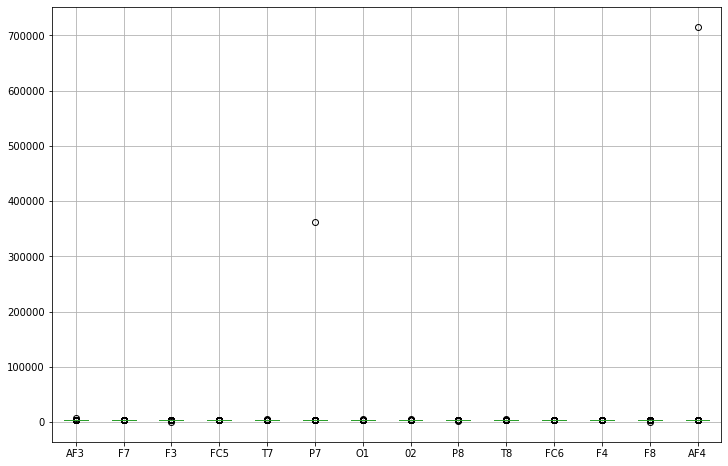

In [12]:
plt.figure(figsize=(12,8))
train.boxplot()
plt.show()

We notice some very outlying feature values. Should we remove these?

In this case we remove all values that are larger than three standard deviations from the mean: 

In [13]:
from scipy import stats

print(train.shape)
tmp = (np.abs(stats.zscore(train)) < 3).all(axis=1)
train_filtered = train[tmp]
train_filtered_label = train_label[tmp]
print(train_filtered.shape)

(5000, 14)
(4845, 14)


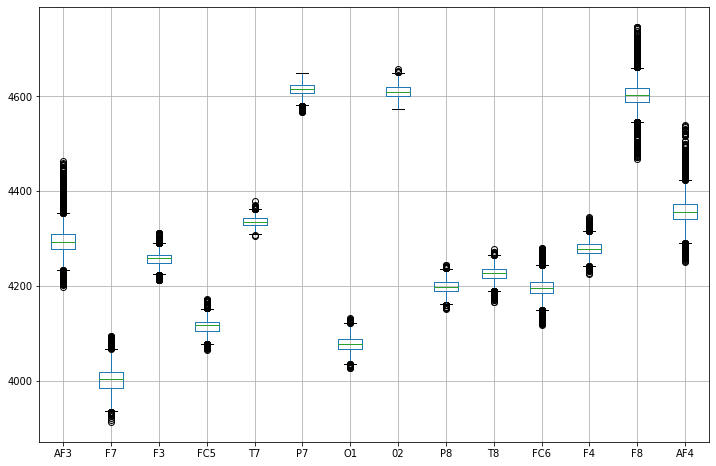

In [14]:
plt.figure(figsize=(12,8))
train_filtered.boxplot()
plt.show()

Now, let's standardize the feature values for each feature:

In [15]:
from sklearn import preprocessing

scaler_std = preprocessing.StandardScaler()
scaler_std.fit(train_filtered)
train_norm = pd.DataFrame(scaler_std.transform(train_filtered),columns=train.columns)
train_norm.head()

,AF3,F7,F3,FC5,T7,P7,O1,02,P8,T8,FC6,F4,F8,AF4
0,0.984882,0.263434,2.277335,2.030053,1.476378,-2.097889,1.006430,2.203548,1.657562,0.781273,0.682142,0.096464,1.044495,1.005616
1,0.843913,0.083341,2.610958,2.062502,0.629651,-2.058512,1.033999,2.056869,0.848012,-0.015338,0.509676,0.028338,0.946353,0.722998
2,0.937791,0.163426,2.721444,2.551787,0.100576,-2.291744,1.006430,1.436684,0.626965,-0.327496,0.460674,0.199320,0.815710,0.871698
3,0.969287,0.363442,2.795823,2.519337,0.788477,-2.369741,1.033999,1.472998,1.326709,0.573168,0.657642,0.576014,0.930102,1.079821
4,0.890699,0.363442,2.499750,2.225385,1.211324,-2.058512,0.952351,1.253690,0.848012,1.162349,0.756125,0.610745,0.946353,1.139244


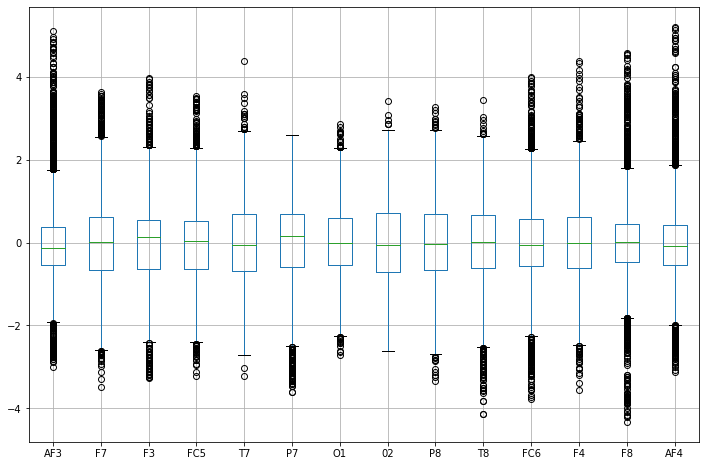

In [16]:
plt.figure(figsize=(12,8))
train_norm.boxplot()
plt.show()

Let's take a look at the EGG signals:

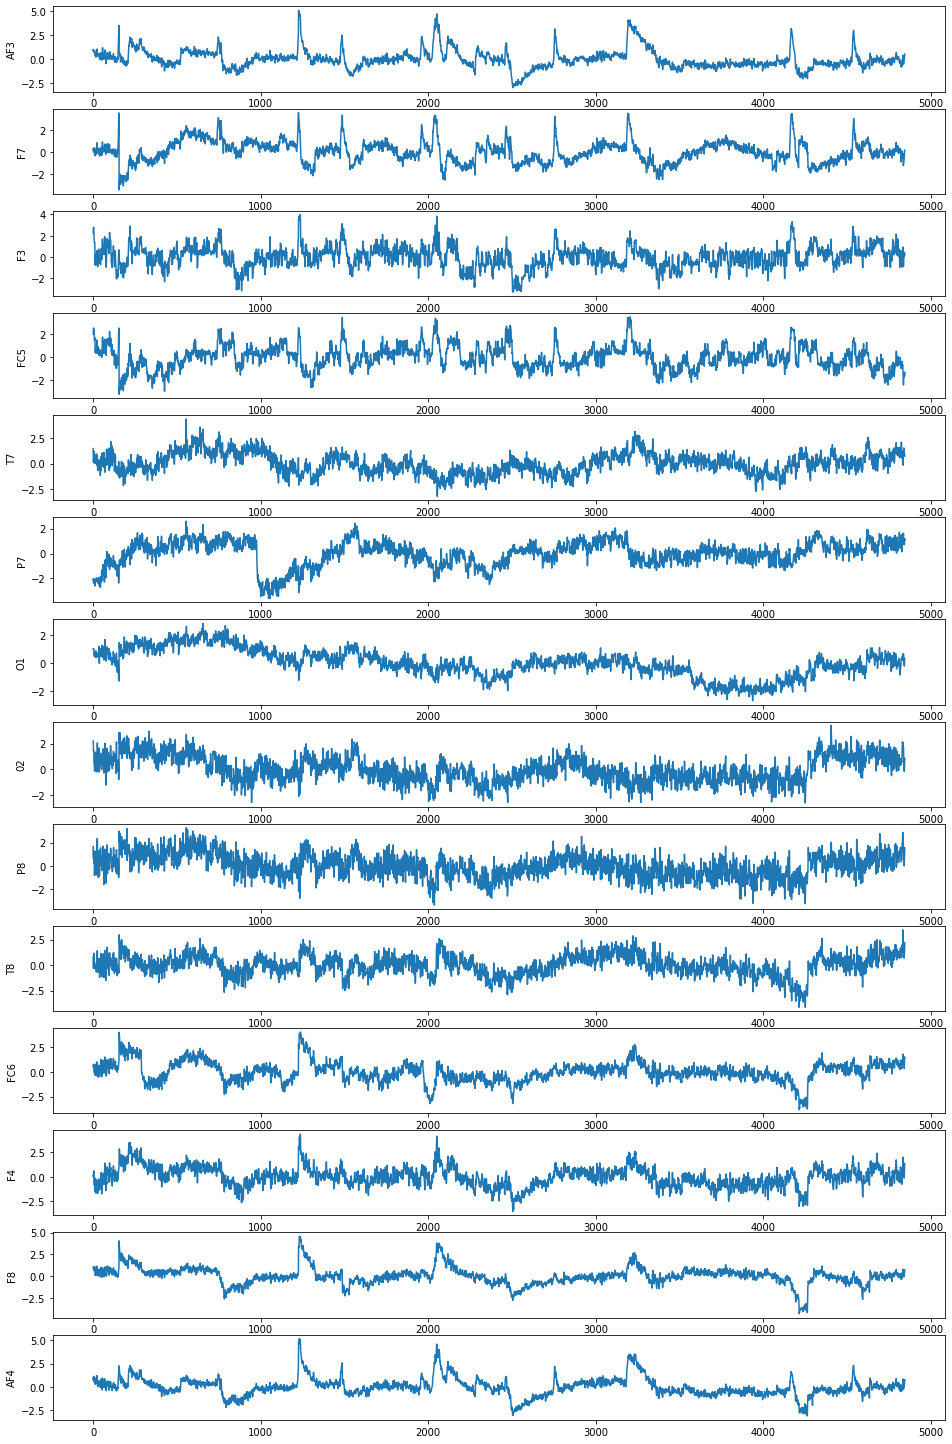

In [50]:
plt.figure(figsize=(16,26))
for i in range(train_norm.shape[1]):
  plt.subplot(train_norm.shape[1], 1, i+1)
  plt.ylabel(train_norm.columns[i])
  plt.plot(train_norm.iloc[:, i])
plt.show()

And let's look at the label in time!

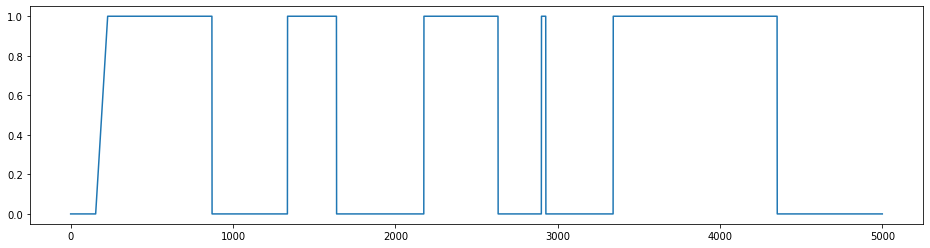

In [51]:
plt.figure(figsize=(16,4))
plt.plot(train_filtered_label)
plt.show()

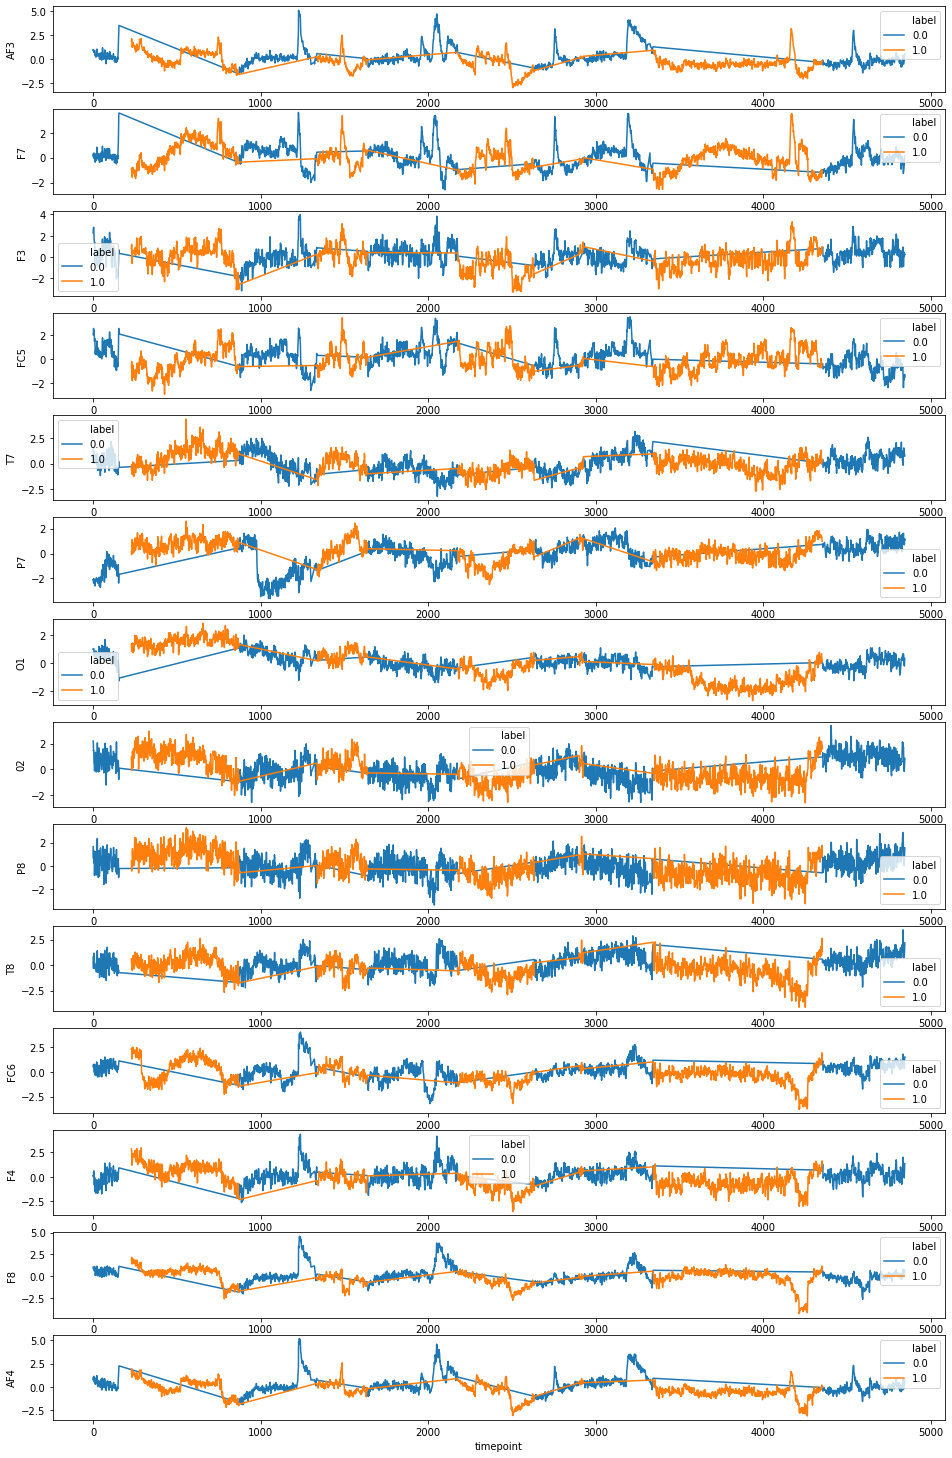

In [58]:
import seaborn as sns

tmp = train_norm.copy()
tmp["timepoint"] = range(len(train_norm))
tmp["label"] = train_filtered_label

plt.figure(figsize=(16,26))
for i in range(tmp.shape[1]-2):
  plt.subplot(tmp.shape[1]-2, 1, i+1)
  sns.lineplot(x="timepoint",y=tmp.columns[i],hue="label",data=tmp)
plt.show()

# 3. Building a decision tree

The scikit-learn `DecisionTreeClassifier` class computes a decision tree predictive model from a dataset. 

To get all the options for learning you can simply type: 

In [19]:
from sklearn.tree import DecisionTreeClassifier
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree._classes:

class DecisionTreeClassifier(sklearn.base.ClassifierMixin, BaseDecisionTree)
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : {"gini", "entropy"}, default="gini"
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : {"best", "random"}, default="best"
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choose
 |      the best random split.
 |  
 |  max_depth : int, default=None
 |      The maximum depth of the tree. If None, then nodes are expanded until
 |      all leaves are pure or until all leaves contain less than
 |      min_samples_split samples.
 |  
 |  min_samples_split : int or float, default=2
 |      The minimum 

Let's create a decision tree model:

In [20]:
cls_DT = DecisionTreeClassifier()

This creates a decision tree model with default values for the hyperparameters:

In [21]:
cls_DT

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Now we can fit the trainset in just one line of code:

In [22]:
cls_DT.fit(train_norm,train_filtered_label)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Let's see how well the decision tree performs on the trainset:

In [23]:
from sklearn.metrics import accuracy_score

predictions = cls_DT.predict(train_norm)
print("Accuracy: %f"%(accuracy_score(predictions, train_filtered_label)))

Accuracy: 1.000000


Great! With just a few lines of code we obtain a perfect fit!

These are the predictions for the first 20 data points:

In [24]:
predictions[0:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

The following code plots the fitted decision tree `cls` as a `tree.png` file:

In [25]:
"""
from sklearn import tree
from io import StringIO
from IPython.display import Image, display
import pydotplus

out = StringIO()
tree.export_graphviz(cls_DT, out_file=out)
graph=pydotplus.graph_from_dot_data(out.getvalue())
graph.write_png("tree.png")
"""

'\nfrom sklearn import tree\nfrom io import StringIO\nfrom IPython.display import Image, display\nimport pydotplus\n\nout = StringIO()\ntree.export_graphviz(cls_DT, out_file=out)\ngraph=pydotplus.graph_from_dot_data(out.getvalue())\ngraph.write_png("tree.png")\n'

# 4. Kaggle evaluation

Let's make a Kaggle submission:

In [26]:
#code for submission
"""
index_col = test.pop("index")
predictions_test = cls_DT.predict(test)

out_tmp = pd.DataFrame()
out_tmp["index"] = index_col
out_tmp["eyeDetection"] = predictions_test
out_tmp.to_csv("submission.csv",index=False)
"""

'\nindex_col = test.pop("index")\npredictions_test = cls_DT.predict(test)\n\nout_tmp = pd.DataFrame()\nout_tmp["index"] = index_col\nout_tmp["eyeDetection"] = predictions_test\nout_tmp.to_csv("submission.csv",index=False)\n'

How does the model perform on the testset? Why could that be?

# 5. The test set

Since we don't have the testset `eyeDetection` labels we cannot check overfitting on the testset before submitting our predictions. So we need to create our own testset (**not seen during training!**) with known class labels.

Scikit-learn offers many options to do this. One of them is the `train_test_split` function:

In [27]:
train_norm.shape

(4845, 14)

In [28]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(train_norm,train_filtered_label,
                                                  test_size=.2, random_state=random_seed)

train_X = train_norm.iloc[0:3000,:]
train_y = train_filtered_label.iloc[0:3000]
val_X = train_norm.iloc[3000:,:]
val_y = train_filtered_label.iloc[3000:]

#train fold
print(train_X.shape)
print(train_y.shape)
#validation fold
print(val_X.shape)
print(val_y.shape)

(3000, 14)
(3000,)
(1845, 14)
(1845,)


Fit a decision tree model with default paramters on the `train_X` data set.

In [29]:
#solution
cls_DT.fit(train_X,train_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

What is the accuracy on `train_X`? 

In [30]:
#solution
predictions = cls_DT.predict(train_X)
print("Accuracy: %f"%(accuracy_score(predictions, train_y)))

Accuracy: 1.000000


What is the accuracy on `val_X`?

In [31]:
#solution
predictions = cls_DT.predict(val_X)
print("Accuracy: %f"%(accuracy_score(predictions, val_y)))

Accuracy: 0.707317


What do you see?


# 4. Hyperparameters

Let's look at the  `DecisionTreeClassifier` again.

In [32]:
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree._classes:

class DecisionTreeClassifier(sklearn.base.ClassifierMixin, BaseDecisionTree)
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : {"gini", "entropy"}, default="gini"
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : {"best", "random"}, default="best"
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choose
 |      the best random split.
 |  
 |  max_depth : int, default=None
 |      The maximum depth of the tree. If None, then nodes are expanded until
 |      all leaves are pure or until all leaves contain less than
 |      min_samples_split samples.
 |  
 |  min_samples_split : int or float, default=2
 |      The minimum 

Notice that there are many parameters (**hyperparameters**) that influence the contruction of a decision tree. One of them is `max_depth` that limits the depth of the contructed decicison tree. The following code evaluates different values for this hyperparameter.

In [33]:
for maxdepth in range(3,20,1):
    cls = DecisionTreeClassifier(max_depth=maxdepth)
    cls.fit(train_X,train_y)
    predictions_train = cls.predict(train_X)
    predictions_val = cls.predict(val_X)
    print("%i %f %f"%(maxdepth,accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

3 0.807000 0.712195
4 0.858667 0.712195
5 0.868333 0.692141
6 0.901000 0.659079
7 0.927000 0.661789
8 0.951333 0.692683
9 0.965333 0.660163
10 0.977000 0.691599
11 0.984333 0.679675
12 0.991333 0.702439
13 0.994000 0.690515
14 0.997333 0.694851
15 0.999333 0.680217
16 1.000000 0.702981
17 1.000000 0.680217
18 1.000000 0.687805
19 1.000000 0.682927


Construct a decision tree with `max_depth` equal to `None` and print the first 20 predictions on the train set. 

In [34]:
#solution

These are binary class predictions (0 or 1). Sometimes it makes sense to predict the probalbility of a data point to belong to a certain class (typically class 1 which is also known as the positive class).

In [35]:
predictions_train = cls_DT.predict_proba(train_X)
print(predictions_train[0:20])

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


The frist column shows the probability of a data point to belong to class 0 and the second column shows the probability of a data point to belong to class 1. What do you see? Why is this?

Can you contruct a decision tree that does not just output 0 or 1 probabilities?

In [36]:
#solution

Play with the hyperparameters in a Template notebook and make some Kaggle submissions.

# 5. Ensemble learning: bagging

We have seen that bias and variance play an important role in Machine Learning. Let's first see what bagging can do for our data set. 

In [37]:
from sklearn.ensemble import BaggingClassifier

cls_bagged = BaggingClassifier(base_estimator=DecisionTreeClassifier(),random_state=random_seed)
                                                            
cls_bagged.fit(train_X,train_y)
predictions_train = cls_bagged.predict(train_X)
predictions_val = cls_bagged.predict(val_X)
print("%f %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

0.998333 0.669919


With the `RandomForestClassifier` the variance of the decision tree is reduced also by selecting features for decision tree contruction at random. Let's see how far we get with default hyperparameter values.   

In [38]:
from sklearn.ensemble import RandomForestClassifier

cls_RF = RandomForestClassifier(random_state=random_seed)
cls_RF.fit(train_X,train_y)
predictions_train = cls_RF.predict(train_X)
predictions_val = cls_RF.predict(val_X)
print("%f %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

1.000000 0.701355


Now let's see what we can do with the `RandomForestClassifier`.

In [39]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble._forest:

class RandomForestClassifier(ForestClassifier)
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is always the same as the original
 |  input sample size but the samples are drawn with replacement if
 |  `bootstrap=True` (default).
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------
 |  n_estimators : integer, optional (default=100)
 |      The number of trees in the forest.
 |  
 |      .. versionchanged:: 0.22
 |         The default value of ``n_estimators`` changed from 10 to 100
 |         in 0.22.
 |  
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the

What happens when you increase the `n_estimators` hyperparameter? 

In [40]:
#solution

# 6. Ensemble learning: boosting

How about the `GradientBoostingClassifier`?

In [41]:
#solution
from sklearn.ensemble import GradientBoostingClassifier

cls_GB = GradientBoostingClassifier(random_state=random_seed,max_depth=10)
cls_GB.fit(train_X,train_y)
predictions_train = cls_GB.predict(train_X)
predictions_val = cls_GB.predict(val_X)
print("%f %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

1.000000 0.706775


# 7. Logistic regression

Before we evaluate other Machine Learning algorithms such as logistic regression we need to look at the distributions and scales of the features. In fact, this should always be the first thing to do when analyzing a new data set.

In Pandas we can create a boxplot for each of the features as follows:

In [42]:
X.boxplot()

NameError: ignored

What do we see?

There are many approaches to outlier detection and removal. Let's use a simple one:

In [ ]:
from scipy import stats

print(X.shape)
tmp = (np.abs(stats.zscore(X)) < 3).all(axis=1)
X_clean = X[tmp]
y_clean = y[tmp]
print(X_clean.shape)

In [ ]:
X_clean.boxplot()

This should look much better.

However, feature values between features are still at very different scales. We need to normalize them. 

In [ ]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler.fit(X_clean)
X_norm = pd.DataFrame(scaler.transform(X_clean),columns=X_clean.columns)

In [ ]:
X_norm.boxplot()

Now each feature is at a similar scale.

Let's start with `LogisticRegression`.

In [ ]:
from sklearn.linear_model import LogisticRegression

train_X, val_X, train_y, val_y = train_test_split(X_norm,y_clean,test_size=.2, random_state=random_seed)

cls_LR=LogisticRegression()
cls_LR.fit(train_X,train_y)
predictions_train = cls_LR.predict(train_X)
predictions_val = cls_LR.predict(val_X)
print("%f %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

Does this perform well?

What could be the reason?

# 8. Non-linear transformations

What does linear classification mean?

In [ ]:
import seaborn as sns

dataset_tmp = pd.read_csv('svm_example1.csv')

sns.lmplot(x="x1", y="x2", data=dataset_tmp, hue='y', markers=['o','+'], 
           fit_reg=False, height=5, scatter_kws={"s": 80})

In [ ]:
import imp
compomics_import = imp.load_source('compomics_import', 'compomics_import.py')

X_tmp = dataset_tmp.copy()
y_tmp = X_tmp.pop('y')

cls_LR.fit(X_tmp,y_tmp)

sns.lmplot(x="x1", y="x2", data=dataset_tmp, hue='y', markers=['o','+'], 
           fit_reg=False, height=5, scatter_kws={"s": 80})
compomics_import.plot_svm_decision_function(cls_LR)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

polynomial_features = PolynomialFeatures(degree=2)
model = Pipeline([("polynomial_features", polynomial_features),
                         ("LR", cls_LR)])
model.fit(X_tmp,y_tmp)

sns.lmplot(x="x1", y="x2", data=dataset_tmp, hue='y', markers=['o','+'], 
           fit_reg=False, height=5, scatter_kws={"s": 80})
compomics_import.plot_svm_decision_function(model)

What happens when you increase the degree?

In [ ]:
#solution

Would this work on our dataset?

In [ ]:
#solution 

Kaggle submission?

The following code ranks the features based on the value of the hyperparameters:

In [ ]:
indices = np.argsort(cls_LR.coef_[0])[::-1]
fnames = poly.get_feature_names()
for i in range(len(fnames)):
    print("%f\t%s"%(cls_LR.coef_[0][indices[i]],fnames[indices[i]]))


What is wrong with this code?

In [ ]:
#solution

# 9. Support Vector Machines

Let's see what an SVM can do with an RBF kernel:

In [ ]:
from sklearn.svm import SVC

model = SVC(kernel='poly',C=1,degree=2)
model.fit(X_tmp,y_tmp)

sns.lmplot(x="x1", y="x2", data=dataset_tmp, hue='y', markers=['o','+'], 
           fit_reg=False, height=5, scatter_kws={"s": 80})
compomics_import.plot_svm_decision_function(model)

In [ ]:
dataset2_tmp = pd.read_csv("svm_example2.csv")
X_tmp = dataset2_tmp.copy()
y_tmp = X_tmp.pop('y')

model = SVC(kernel='rbf',C=1,gamma=1)
model.fit(X_tmp,y_tmp)

sns.lmplot(x="x1", y="x2", data=dataset2_tmp, hue='y', markers=['o','+'], 
           fit_reg=False, height=5, scatter_kws={"s": 80})
compomics_import.plot_svm_decision_function(model)

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(X_norm,y_clean,test_size=.2, random_state=random_seed)

cls_SVM = SVC(kernel='rbf')
cls_SVM.fit(train_X,train_y)
predictions_train = cls_SVM.predict(train_X)
predictions_val = cls_SVM.predict(val_X)
print("%f %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

# 10. Neural Networks

How about a Neural Network?

In [ ]:
from sklearn.neural_network import MLPClassifier

cls_MLP=MLPClassifier(hidden_layer_sizes=(60,10))
cls_MLP.fit(train_X,train_y)
predictions_train = cls_MLP.predict(train_X)
predictions_val = cls_MLP.predict(val_X)
print("%f %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

Is feature normalization required?

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(X,y,test_size=.2, random_state=random_seed)
cls_MLP.fit(train_X,train_y)
predictions_train = cls_MLP.predict(train_X)
predictions_val = cls_MLP.predict(val_X)
print("%f %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))